# Import necessary librairies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import time
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import train_test_split

### Define useful functions

In [2]:
def display_time(start, stop):
    total = stop - start
    hours = total // 3600
    minutes = (total - 3600*hours) // 60
    seconds = int((total - 3600*hours) % 60)
    
    if hours > 0:
        print(f"Process took {hours}h, {minutes}min, {seconds}s to run")
    elif minutes > 0:
        print(f"Process took {minutes}min, {seconds}s to run")
    else:
        print(f"Process took {seconds}s to run")

# Data processing

### Load and process the data

In [3]:
# import the data from the full database
df = pd.read_csv("", sep = ',', engine='python')

In [4]:
# process the data to avoid later errors
df = df.replace(float("nan"), "")

### Text embedding and encoding

$$ 
\text{We use a pre-trained model built by Google to encode the text data, so as to allow computers to read and understand it.}
$$

In [7]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [8]:
def encode_string(string):
    return list(hub_layer([string]).numpy()[0])

### Create the data and classes

In [9]:
classes = np.unique(df["contact_job_function"])

In [10]:
def get_index(array, elem):
    for i in range(len(array)):
        if array[i] == elem:
            return i
    return -1

In [ ]:
# X contain the features and y contains the indices of the classes associated

X, y = [], []
for i in tqdm(range(len(df))):
    class_index = get_index(classes, df.iloc[i]["job_function"])
    y.append(class_index)

    encode_roles = [encode_string(df.iloc[i]["job_selfrep"])]
    encode_roles += [encode_string(df.iloc[i]["job_role"])]
    encode_roles += [encode_string(df.iloc[i]["job_title"])]
    X.append(encode_roles)

### Reshape the data

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

In [15]:
y = to_categorical(y)

### Split the data into training and test sets

- We split the whole dataset into 3 differents sets, for the training, the validation and the tests
     - Training dataset :   75% of the whole dataset
     - Validation dataset : 15% of the whole dataset
     - Test dataset :       10% of the whole dataset

In [16]:
def train_val_test(dataX, dataY, train_ratio=0.75, validation_ratio=0.15, test_ratio=0.10):
    if train_ratio+test_ratio+validation_ratio != 1:
        print("Ratios do not add up to 1")
    else:
        x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

        return x_train, x_val, x_test, y_train, y_val, y_test

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(X, y)

# Build our Neural Network

In [19]:
input_dimension = len(X[0])
output_dimension = 64

# we use this to randomly initialize the weights in the dense layers, which allows for a faster convergence of the network
kernel_initializing = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=666)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_dimension, activation='selu', kernel_initializer=kernel_initializing),
    tf.keras.layers.Reshape((input_dimension, 1)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(output_dimension, dropout=0.2)),
    tf.keras.layers.Dense(output_dimension, activation='elu', kernel_initializer=kernel_initializing),
    
    tf.keras.layers.Dense(len(classes), activation='softmax', kernel_initializer=kernel_initializing)
])

In [20]:
model.build(X.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1937682, 150)            22650     
                                                                 
 reshape (Reshape)           (1937682, 150, 1)         0         
                                                                 
 bidirectional (Bidirectiona  (1937682, 128)           33792     
 l)                                                              
                                                                 
 dense_1 (Dense)             (1937682, 64)             8256      
                                                                 
 dense_2 (Dense)             (1937682, 42)             2730      
                                                                 
Total params: 67,428
Trainable params: 67,428
Non-trainable params: 0
____________________________________________________

In [21]:
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adamax(),
          metrics=['accuracy'])

In [22]:
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

callbacks = [checkpoint, es]

In [23]:
start=time.time()

model = keras.models.load_model(filepath)
history = model.fit(X_train, y_train, batch_size = 512, epochs=150, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

stop=time.time()
display_time(start, stop)

Epoch 1/150
2839/2839 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9332
Epoch 1: val_loss improved from inf to 0.26492, saving model to ./models/tryouts\model.h5
2839/2839 [==============================] - 2804s 986ms/step - loss: 0.2428 - accuracy: 0.9332 - val_loss: 0.2649 - val_accuracy: 0.9284
Epoch 2/150
2839/2839 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9335
Epoch 2: val_loss improved from 0.26492 to 0.26126, saving model to ./models/tryouts\model.h5
2839/2839 [==============================] - 3016s 1s/step - loss: 0.2410 - accuracy: 0.9335 - val_loss: 0.2613 - val_accuracy: 0.9297
Epoch 3/150
2839/2839 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9339
Epoch 3: val_loss improved from 0.26126 to 0.24496, saving model to ./models/tryouts\model.h5
2839/2839 [==============================] - 3276s 1s/step - loss: 0.2392 - accuracy: 0.9339 - val_loss: 0.2450 - val_accuracy: 0.9332
Epoch 4/150
2839/

# Evaluate our model

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [25]:
def plot_history(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)
    plt.show()

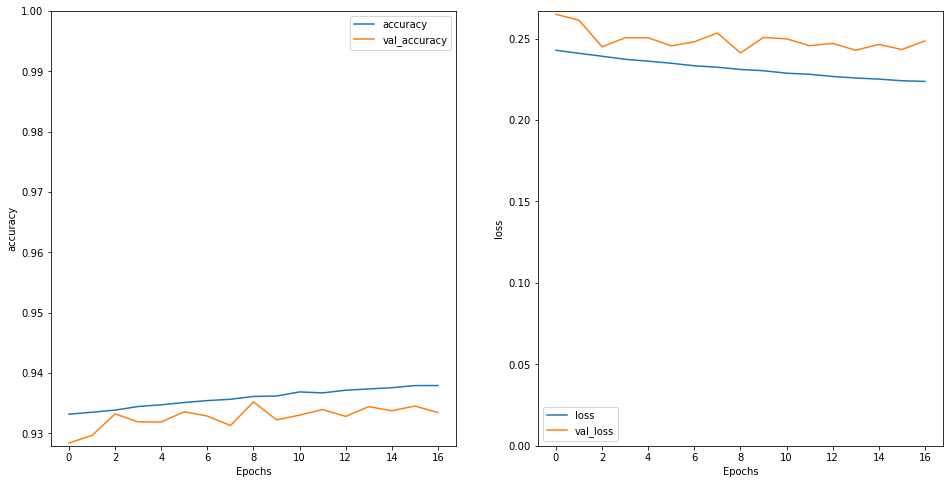

In [26]:
plot_history(history)

In [27]:
def get_class_predicted(categories):
    return [np.argmax(category) for category in categories]

def prediction_and_accuracy(model, X_for_testing, y_for_testing, print_=True):
    all_class_prediction = model.predict(X_for_testing)
    prediction = get_class_predicted(all_class_prediction)
    y = get_class_predicted(y_for_testing)
    
    accuracy = metrics.accuracy_score(y, prediction)
    
    if print_:
        print(f"Accuracy -> {round(100*accuracy, 2)}%")
    return prediction, accuracy

#### Get the accuracy on the test set

In [28]:
minimum_val_loss_model = keras.models.load_model(filepath)
vect_prediction, accuracy = prediction_and_accuracy(minimum_val_loss_model, X_test, y_test)

6056/6056 [==============================] - 266s 44ms/step
Accuracy -> 93.52%
